### CDS ERA5 data ingestion
- Objective: this notebook ingests monthly averaged climate reanalysis data for temperature and total precipitation
- Output: NetCDF files that will be further aggregated at district level

Import modules

In [1]:
# Import necessary libraries
import xarray as xr
import cdsapi
import xarray as xr
import rioxarray
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import os

Load shapefiles to clip netCDF data

In [2]:
# Load India shapefile
india_shapefile = gpd.read_file(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\SHAPEFILE\gadm36_IND_0.shp").to_crs("epsg:4326")
india_geometry = india_shapefile.geometry

Download net CDf data via API

In [4]:
# download raw netCDF data 
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            '2m_temperature',
            'total_precipitation',
            'leaf_area_index_low_vegetation',
            'potential_evaporation',
            'surface_pressure',
            'volumetric_soil_water_layer_1'
        ],
        'year': [
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021', '2022', '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            35.5, 68.2, 8, 97.5  # North, West, South, East
        ],
    },
     r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\weather_data.nc')

2023-12-14 12:20:04,322 INFO Welcome to the CDS
2023-12-14 12:20:04,323 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-12-14 12:20:04,489 INFO Request is queued
2023-12-14 12:20:09,375 INFO Request is running
2023-12-14 12:24:22,838 INFO Request is completed
2023-12-14 12:24:22,839 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data6/adaptor.mars.internal-1702553012.8574572-4300-13-07012ee3-e481-4ad9-bcac-06c94c7b6086.nc to C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\weather_data.nc (86M)
2023-12-14 12:24:32,353 INFO Download rate 9M/s     


Result(content_length=90223580,content_type=application/x-netcdf,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data6/adaptor.mars.internal-1702553012.8574572-4300-13-07012ee3-e481-4ad9-bcac-06c94c7b6086.nc)

Check the downloaded data

In [10]:
# Load Climate data (.nc format)
climate_data = xr.open_dataset(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\weather_data.nc")

In [12]:
# Convert temperature to celsius  
climate_data['t2m'] = climate_data['t2m'] - 273.15

In [13]:
# clip to shapefile
climate_data_clipped_shapefile = climate_data.rio.write_crs("epsg:4326").rio.clip(india_geometry)

In [15]:
climate_data_clipped_shapefile

<xarray.Dataset>
Dimensions:      (longitude: 116, latitude: 109, expver: 2, time: 287)
Coordinates:
  * longitude    (longitude) float32 68.45 68.7 68.95 69.2 ... 96.7 96.95 97.2
  * latitude     (latitude) float32 35.25 35.0 34.75 34.5 ... 9.0 8.75 8.5 8.25
  * expver       (expver) int32 1 5
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2023-11-01
    spatial_ref  int32 0
Data variables:
    t2m          (time, expver, latitude, longitude) float32 nan nan ... nan nan
    tp           (time, expver, latitude, longitude) float32 nan nan ... nan nan
    lai_lv       (time, expver, latitude, longitude) float32 nan nan ... nan nan
    pev          (time, expver, latitude, longitude) float32 nan nan ... nan nan
    sp           (time, expver, latitude, longitude) float32 nan nan ... nan nan
    swvl1        (time, expver, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-14 11:23:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [17]:
climate_data_clipped_shapefile["t2m"].sel(time="2022-01", method="nearest")

<xarray.DataArray 't2m' (expver: 2, latitude: 109, longitude: 116)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 68.45 68.7 68.95 69.2 ... 96.7 96.95 97.2
  * latitude     (latitude) float32 35.25 35.0 34.75 34.5 ... 9.0 8.75 8.5 8.25
  * expver       (expver) int32 1 5
    time         datetime64[ns] 2022-01-01
    spatial_ref  int32 0

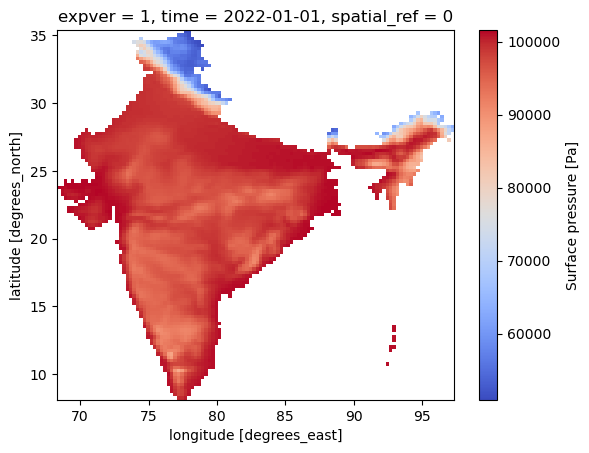

In [30]:
# plot with title as variable name and date
climate_data_clipped_shapefile["sp"].sel(time="2022-01", method="nearest").sel(expver=1).plot(cmap="coolwarm")

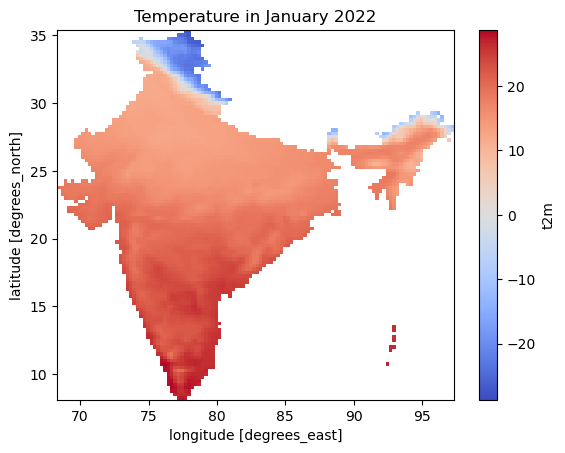

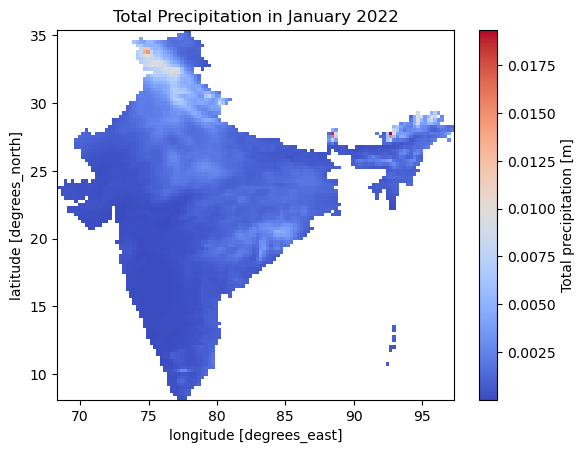

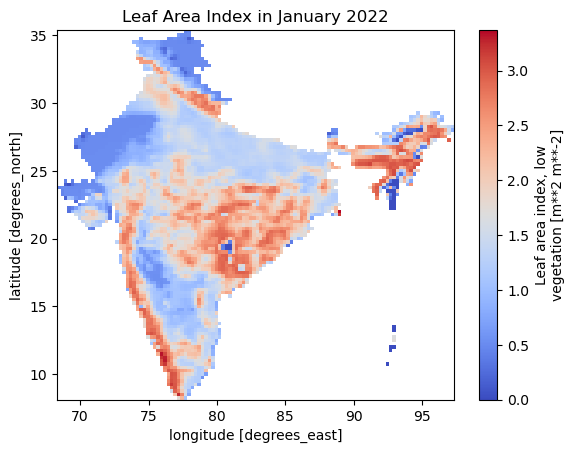

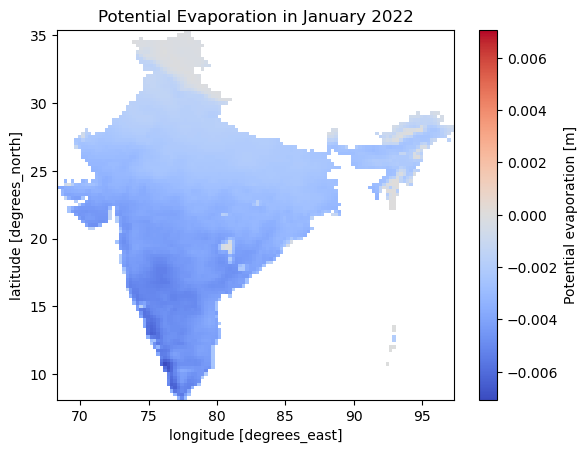

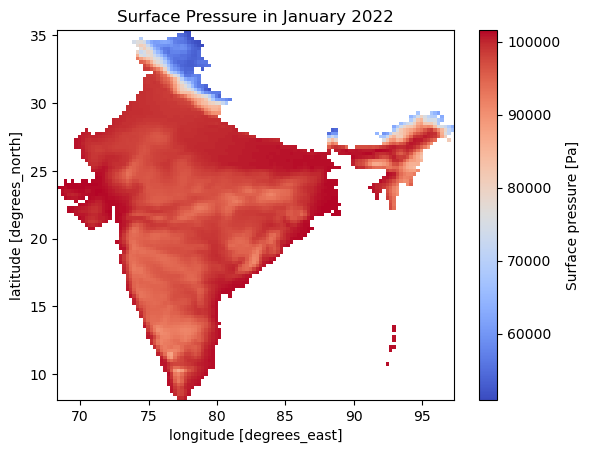

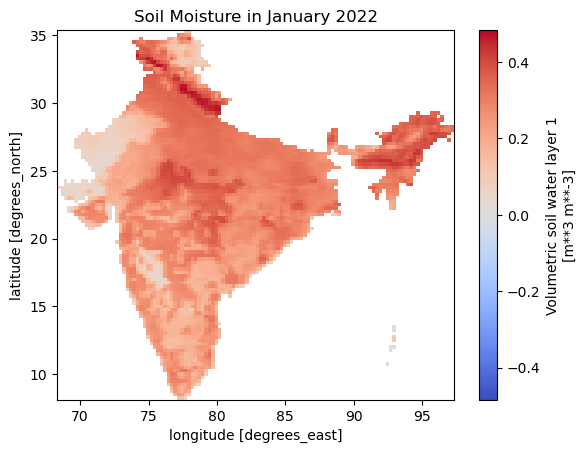

In [34]:
# More descriptive titles for each variable
titles = {
    't2m': 'Temperature in January 2022',
    'tp': 'Total Precipitation in January 2022',
    'lai_lv': 'Leaf Area Index in January 2022',
    'pev': 'Potential Evaporation in January 2022',
    'sp': 'Surface Pressure in January 2022',
    'swvl1': 'Soil Moisture in January 2022'
}

# Loop through each variable and create a plot with updated titles
for var in variables:
    data = climate_data_clipped_shapefile[var].sel(time="2022-01", method="nearest").sel(expver=1)
    data.plot(cmap="coolwarm")
    plt.title(titles[var])  # Use the descriptive title
    plt.show()


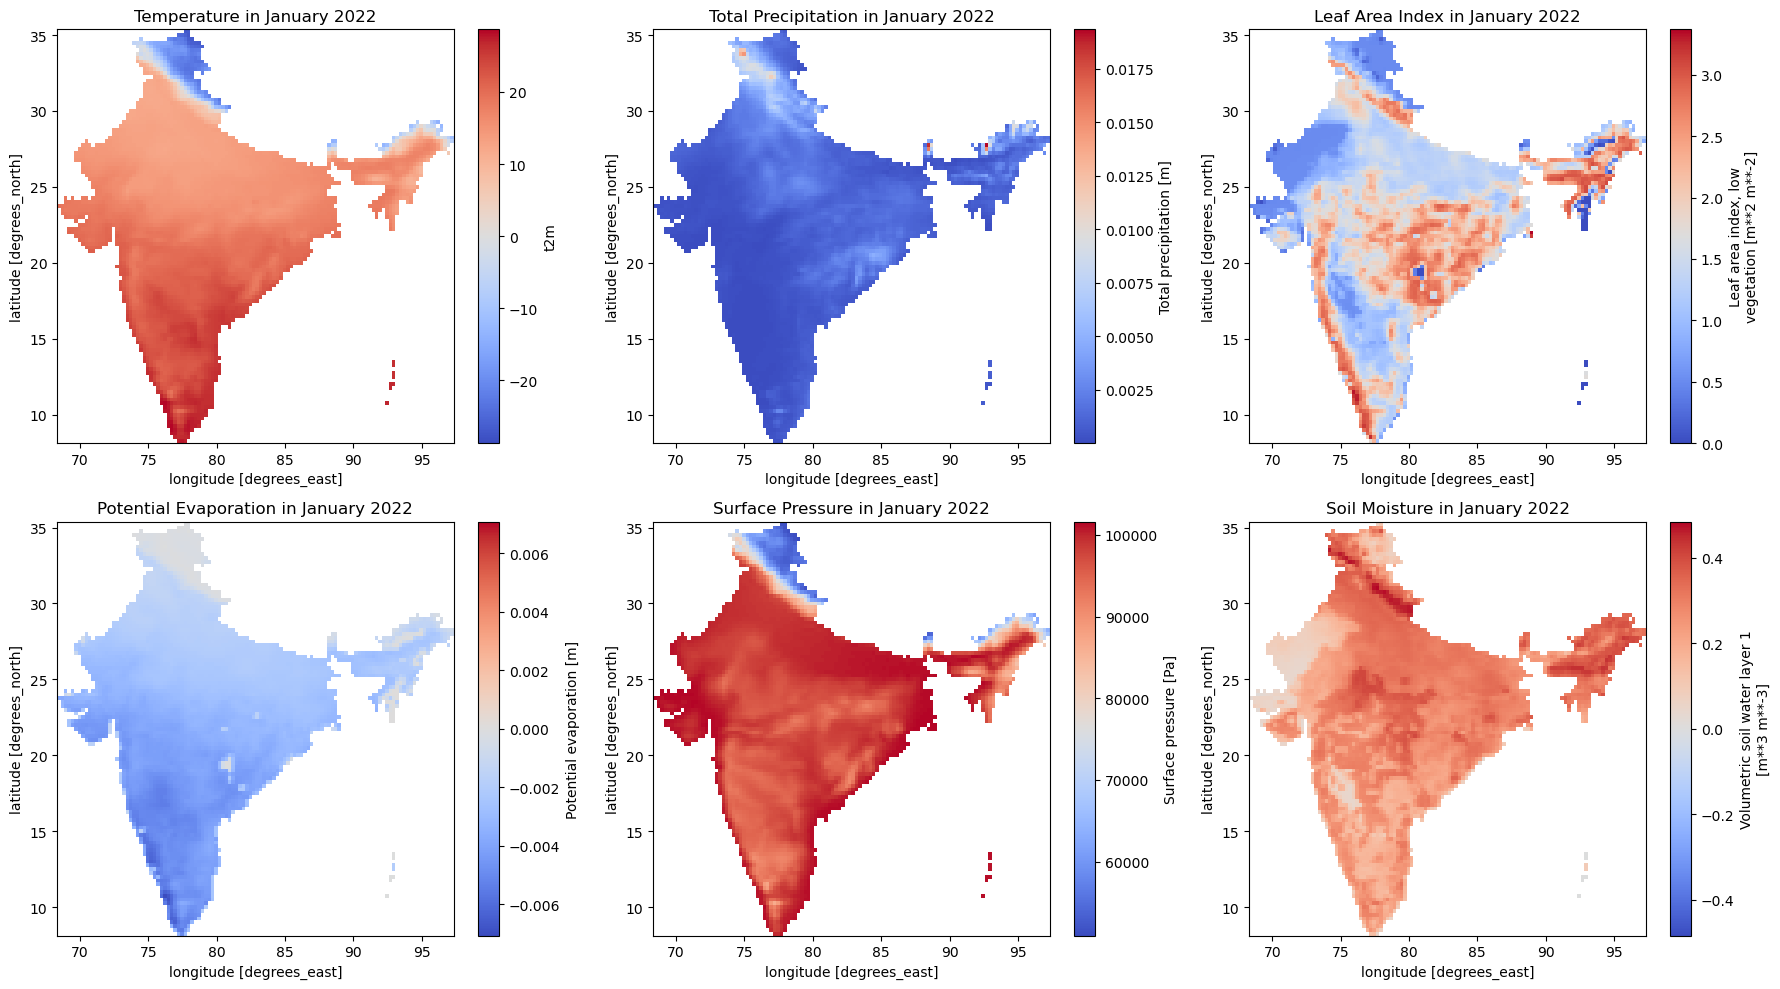

In [44]:
import matplotlib.pyplot as plt

# List of variables to plot
variables = ['t2m', 'tp', 'lai_lv', 'pev', 'sp', 'swvl1']

# Descriptive titles for each variable
titles = {
    't2m': 'Temperature in January 2022',
    'tp': 'Total Precipitation in January 2022',
    'lai_lv': 'Leaf Area Index in January 2022',
    'pev': 'Potential Evaporation in January 2022',
    'sp': 'Surface Pressure in January 2022',
    'swvl1': 'Soil Moisture in January 2022'
}

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the variables and their corresponding axes
for var, ax in zip(variables, axes):
    # Select the variable and time from the dataset
    data = climate_data_clipped_shapefile[var].sel(time="2022-01", method="nearest").sel(expver=1)
    
    # Plot the data on the respective subplot
    data.plot(ax=ax, cmap="coolwarm")
    
    # Set the title for the subplot
    ax.set_title(titles[var])

# Adjust the layout so that plots do not overlap
plt.tight_layout()

# Show the plot
plt.show()
